# 16. Parameter fitting on _A. niger_ data

## Numerical experiments - Week 20/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

## Prerequisite libraries

In [2]:
using PyPlot
using BlackBoxOptim
using JLD2
using Statistics
using Revise
using Printf

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./setup.jl")
Revise.includet("./plotting.jl")
Revise.includet("./analysis.jl")
Revise.includet("./datautils.jl")
Revise.includet("./germstats.jl")
using .Conversions
using .Diffusion
using .Setup
using .Plotting
using .Analysis
using .DataUtils
using .GermStats

## 1. Time-dependent Dantigny dataset generation

The estimated $P_{\textrm{max}}$, $\tau_g$ and $\nu$ parameters from Ijadpanahsaravi et al. [1] allow the reconstruction of time-dependent courses of the germination percentage. This is useful for providing more data points to fit the different inducer-inhibitor interaction models outlined in the previous notebook.

The data points for the arginine-rich medium are removed, since they have a broad variance and semi-saturation times longer than the documented time period.

In [3]:
t_max = 48
df_germination_rebuilt = parse_ijadpanahsaravi_data()
df_germination_rebuilt = filter(row -> row[1] != "Arg", df_germination_rebuilt) # Remove "Arg" from the dataset
dantigny_data, times, sources, densities, errs, p_maxs, taus, nus = generate_dantigny_dataset(df_germination_rebuilt, t_max)
size(dantigny_data)

(2, 4, 1000)

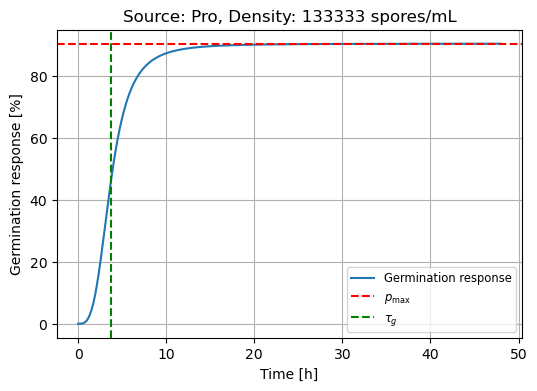

In [ ]:
src_idx = 2
density_idx = 3
# params_data = filter(row -> (row[:CarbonSource] == sources[src_idx]) && (row[:Density] == densities[density_idx]), df_germination_rebuilt)
plot_dantigny_time_course(p_maxs[src_idx, density_idx], taus[src_idx, density_idx], nus[src_idx, density_idx],
                            germ_responses=dantigny_data[src_idx, density_idx, :], times=times,
                            title="Source: $(sources[src_idx]), Density: $(round(Int,densities[density_idx])) spores/mL")

## 2. Optimising the probability computation

### 2.1. Gauss-Hermite approximation

The fitting procedure involves many executions of the probability calculation functions, which is computationally costly given the integral terms. Since the integration is over Gaussian probabilities, a Gauss-Hermite quadrature can be employed to compute the integrals much more efficiently. This requires the conversion of integration variables to standard Notmal variables first. In the case of $\xi$, one can define

$$
\begin{equation}
u=\frac{\xi-\mu_\xi}{\sigma_\xi} \implies \xi = \mu_\xi + \sigma_\xi u, \quad d{\xi}=\sigma_\xi d{u}.
\end{equation}
$$

If $\xi$ runs from $0$ to $+\infty$, then the interval of $u$ is from $u_0=\frac{-\mu_\xi}{\sigma_\xi}$ to $+\infty$. Hence, an integral like

$$
\begin{equation}
I=\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ \frac{1}{\sqrt{2\pi}\sigma_\xi}\exp{\left(-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}\right)}\ d{\xi}}
\end{equation}
$$

becomes

$$
\begin{equation}
I=\int_{u_0}^\infty{\left[1-\Phi{\left(\frac{\beta{(\mu_\xi + \sigma_\xi u)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ \frac{1}{\sqrt{2\pi}}\exp{\left(-\frac{u^2}{2}\right)}\ d{u}}.
\end{equation}
$$

Since the probability of $\xi$ being negative is negligible, the Gauss-Hermite approximation can be made:

$$
\begin{equation}
I=\int_{-\infty}^\infty{f{(u)}\ d{u}}\approx \int_{u_0}^\infty{f{(u)}\ d{u}}\approx \sum_{i=1}^{N}{w_if{(x)}},
\end{equation}
$$

where $w_i$ are precomputed weights. A weight count of $N=30$ is theoretically estimated to suffice for machine precision. To test this, the procedure below examines the convergence of a simple probability computation under increasing number of Gauss-Hermite nodes. The values plotted are the over-time maxima of the differences from the over-nodes average.

(30, 100)


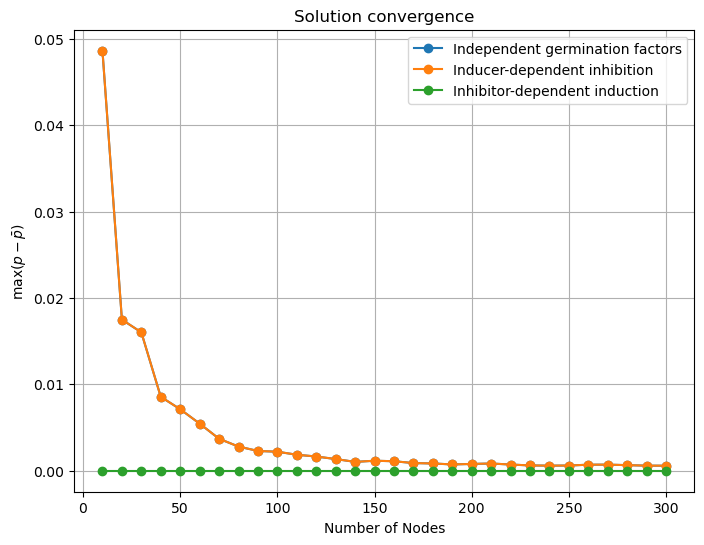

In [3]:
params = Dict(
    :μ_ξ => 2.65,
    :σ_ξ => 0.3,
    :c₀_cs => 0.01,
    :d_hp => 0.01,
    :μ_κ => 0.2,
    :σ_κ => 0.05,
    :Pₛ => 5e-4,
    :Pₛ_cs => 1e-5,
    :μ_γ => 1e-5,
    :σ_γ => 1e-6,
    :k => 1.0,
    :K_I => 0.2,
    :K_cs => 1.0,
    :n => 2.5,
    :s => 0.5,
    :μ_ω => 0.3,
    :σ_ω => 0.2,
    :μ_ψ => 0.5,
    :σ_ψ => 0.01
)

t_max_eval = 5*3600
times_eval = LinRange(0, t_max_eval, 100)
density_test = inverse_mL_to_cubic_um(densities[2])
nodes_range = round.(Int, LinRange(10, 300, 30))

# Compute the germination response for different numbers of nodes
germ_resp_test_A = zeros(Float64, length(nodes_range), length(times_eval))
germ_resp_test_B = zeros(Float64, length(nodes_range), length(times_eval))
germ_resp_test_C = zeros(Float64, length(nodes_range), length(times_eval))
for i in 1:length(nodes_range)
    n = nodes_range[i]
    germ_resp_test_A[i, :] = compute_germination_response("independent", false, times_eval, density_test, params, n_nodes=n)
    germ_resp_test_B[i, :] = compute_germination_response("inhibitor", false, times_eval, density_test, params, n_nodes=n)
    germ_resp_test_C[i, :] = compute_germination_response("inducer", false, times_eval, density_test, params, n_nodes=n)
end

println(size(germ_resp_test_A))

# Compute deviations
dev_A = maximum(germ_resp_test_A .- mean(germ_resp_test_A, dims=1), dims=2)
dev_B = maximum(germ_resp_test_B .- mean(germ_resp_test_B, dims=1), dims=2)
dev_C = maximum(germ_resp_test_C .- mean(germ_resp_test_C, dims=1), dims=2)

# Plot solution vs number of nodes
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(nodes_range, dev_A, marker="o", label="Independent germination factors")
ax.plot(nodes_range, dev_B, marker="o", label="Inducer-dependent inhibition")
ax.plot(nodes_range, dev_C, marker="o", label="Inhibitor-dependent induction")
ax.set_xlabel("Number of Nodes")
ax.set_ylabel(L"\max{(p-\bar{p})}")
ax.set_title("Solution convergence")
ax.grid(true)
ax.legend()

gcf()

This study shows that the models involving higher-dimension integrals are less sensitive to the number of Gauss-Hermite nodes in one dimension. Therefore, to avoid redundant computation, the number of nodes per dimension $N$ reduces with increasing number of dimensions $d$ by an exponent of $1/d$:

- $N=216$ for $d=1$;
- $N=36$ for $d=2$;
- $N=10$ for $d=3$;

In the following sections, the probabilities are presented as untransformed integral, while the optimisation procedure manipulates them in the manner outlined above.

### 2.2. Random variable distributions

For all random variables related to a physical quantity, e.g. spore radius, permeability, concentration etc., it is safe to assume a log-Normal distribution instead of a Normal one, as this eliminates the possibility of unrealistic negative values. In the case of the germination thresholds $\gamma$ and $\omega$, which are hypothetically the result of a complex interaction of dependencies, it is less straightforward to make the same assumption. A negative threshold would imply anomalous germination with respect to carbon signalling or inhibition.

If part of the $\gamma$ distribution is negative, it would be implied that part of the spores can never reach the point of inhibitor depletion, causing them to never germinate. While the reasons for failed germination can be numerous (e.g. genetic defects, physiological damage or locally unfavourable conditions), they can be represented in a negative threshold for inhibitor depletion, which leads to some spores remaining dormant even when the inhibitor concentration is zero.

If part of the $\omega$ distribution is negative, some spores would effectively not need any carbon signal to germinate. It has indeed been observed that spores can anomalously germinate in the total absense of an inducing carbon source, albeit in a very low percentage ($< 5\%$) for _A. niger_. For _A. nidulans_, this fraction can reach up to $50\%$ [2].

Thus, the assumption of a Normal distribution can be maintained for the thresholds, but the ratio between standard deviation and mean needs to be kept in a sensible range. Thus, assuming that up to 5% of the conidia germinate or do not germinate anomalously, at most 5% of the distribution may fall below zero. Expressing this in probabilistic terms,

$$
\begin{equation}
P{(\gamma<0)}=P{\left(\frac{\gamma-\mu_\gamma}{\sigma_\gamma}<\frac{0-\mu_\gamma}{\sigma_\gamma}\right)}=P{(Z<z^*)}=0.05,
\end{equation}
$$

where $Z=\frac{\gamma-\mu_\gamma}{\sigma_\gamma}$ and $z^*=-\frac{\mu_\gamma}{\sigma_\gamma}$ are standardised variables. Solving for $z^*$,

$$
\begin{equation}
z^*=\Phi^{-1}{(0.05)}\approx -1.645.
\end{equation}
$$

Hence,

$$
\begin{equation}
\frac{\sigma_\gamma}{\mu_\gamma}=\frac{1}{1.645}\approx0.61.
\end{equation}
$$

The same calculations apply to the $\omega$ distribution. To constrain the coefficient of variation in the parameter optimisation, the variable $\delta=\log{\frac{\sigma}{\mu}}$ is used. Thus, the upper limit for $\delta$ is approximately $-0.5$.

## 3. Fitting procedures for a static inducer

The following parameter estimations are based on the assumption of a constant level of the carbon source at the receptor proteins, i.e. in the case when the hydrophobin-melanin layer does not impose any temporal delay on the carbon signalling. The objective function minimizes both the difference between time-dependent germination measurements and between steady-state equilibrium probabilities, weighing the latter by the number of time points to preserve its relative importance.

### 3.1. Independent induction/inhibition

As determined previously, the germination probability in the first model follows the formula

$$
\begin{equation}
p(\textrm{germination})=\Phi{\left(\frac{1-\mu_\omega}{\sigma_\omega}\right)}\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ \frac{1}{\sqrt{2\pi}\sigma_\xi}\exp{\left(-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}\right)}\ d{\xi}}.
\end{equation}
$$

In the equilibrium limit, this probability becomes

$$
\begin{equation}
p(\textrm{germination})=\Phi{\left(\frac{1-\mu_\omega}{\sigma_\omega}\right)}\int_0^\infty{\left[1-\Phi{\left(\frac{\phi{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ \frac{1}{\sqrt{2\pi}\sigma_\xi}\exp{\left(-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}\right)}\ d{\xi}}.
\end{equation}
$$

This model is expected to yield different outcomes depending on the inducing source. Since $s$ is normalised, its variation is absorbed by the threshold parameters $\mu_\omega$ and $\sigma_\omega$. The inhibitory effect is by definition independent from carbon signalling. Therefore, all remaining parameters are assumed to be constant over the different carbon sources.

In [4]:
# Define default parameters globally
def_params = Dict(
    :μ_ξ => 2.65,
    :σ_ξ => 0.3,
    :c₀_cs => 0.01,
    :d_hp => 0.01,
    :μ_κ => 0.2,
    :σ_κ => 0.05
)

# Define parameter bounds globally
bounds_narrow = Dict(
    :Pₛ => (1e-4, 1e-3),
    :Pₛ_cs => (1e-7, 1e-2),
    :k => (-6, 6),
    :K_I => (1e-5, 1.0),
    :K_cs => (1e-8, 0.1),
    :n => (1.0, 3.0),
    :s => (1e-6, 1.0),
    :μ_γ => (1e-6, 1e-4),
    :δ_γ => (-10, -0.5),
    :μ_ω => (1e-6, 10.0),
    :δ_ω => (-10, -0.5),
    :μ_ψ => (1e-5, 1.0),	
    :δ_ψ => (-10, 0),
    :μ_π => (1e-4, 1e-3),
    :δ_π => (-10, 0),
    :μ_α => (1e-4, 1.0),
    :δ_α => (-10, 0)
)

bounds_broad = Dict(
    :Pₛ => (1e-5, 1e-2),
    :Pₛ_cs => (1e-8, 1e-2),
    :k => (-6, 6),
    :K_I => (1e-5, 1.0),
    :K_cs => (1e-8, 10.0),
    :n => (1.0, 3.0),
    :s => (1e-6, 1.0),
    :μ_γ => (1e-8, 1e-1),
    :δ_γ => (-10, -0.5),
    :μ_ω => (1e-6, 10.0),
    :δ_ω => (-10, -0.5),
    :μ_ψ => (1e-5, 1.0),	
    :δ_ψ => (-10, 0),
    :μ_π => (1e-4, 1e-3),
    :δ_π => (-10, 0),
    :μ_α => (1e-4, 1.0),
    :δ_α => (-10, 0)
)

Dict{Symbol, Tuple{Real, Real}} with 17 entries:
  :K_I   => (1.0e-5, 1.0)
  :n     => (1.0, 3.0)
  :K_cs  => (1.0e-8, 10.0)
  :δ_ω   => (-10, -0.5)
  :μ_ψ   => (1.0e-5, 1.0)
  :μ_α   => (0.0001, 1.0)
  :δ_ψ   => (-10, 0)
  :δ_α   => (-10, 0)
  :μ_ω   => (1.0e-6, 10.0)
  :μ_π   => (0.0001, 0.001)
  :Pₛ    => (1.0e-5, 0.01)
  :k     => (-6, 6)
  :s     => (1.0e-6, 1.0)
  :δ_π   => (-10, 0)
  :δ_γ   => (-10, -0.5)
  :μ_γ   => (1.0e-8, 0.1)
  :Pₛ_cs => (1.0e-8, 0.01)

In [4]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("independent", def_params, dantigny_data, times, sources, densities, bounds_narrow, p_maxs * 0.01, max_steps=max_steps)

jldopen("Data/fit_independent.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Number of nodes: 216
Model: independent factors with static inducer
Running first optimisation stage
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.55 secs, 8 evals, 4 steps, improv/step: 0.750 (last = 0.7500), fitness=2544.760589035
1.08 secs, 16 evals, 8 steps, improv/step: 0.750 (last = 0.7500), fitness=2544.144657505
1.60 secs, 25 evals, 13 steps, improv/step: 0.769 (last = 0.8000), fitness=2544.144657505
2.14 secs, 36 evals, 19 steps, improv/step: 0.737 (last = 0.6667), fitness=2463.934693795
2.73 secs, 47 evals, 25 steps, improv/step: 0.680 (last = 0.5000), fitness=2463.934693795
3.28 secs, 58 evals, 31 steps, improv/step: 0.710 (last = 0.8333), fitness=2463.934693795
3.85 secs, 68 evals, 38 steps, improv/step: 0.711 (last = 0.7143), fitness=2442.576255075
4.42 secs, 79 evals, 45 steps, improv/step: 0.733 (last = 0.8571), f

Dict{Any, Any} with 5 entries:
  :σ_γ => [2.11257e-5]
  :μ_ω => [0.713886, 0.177565]
  :μ_γ => [3.83775e-5]
  :Pₛ  => [0.000521917]
  :σ_ω => [0.212298, 0.00788105]

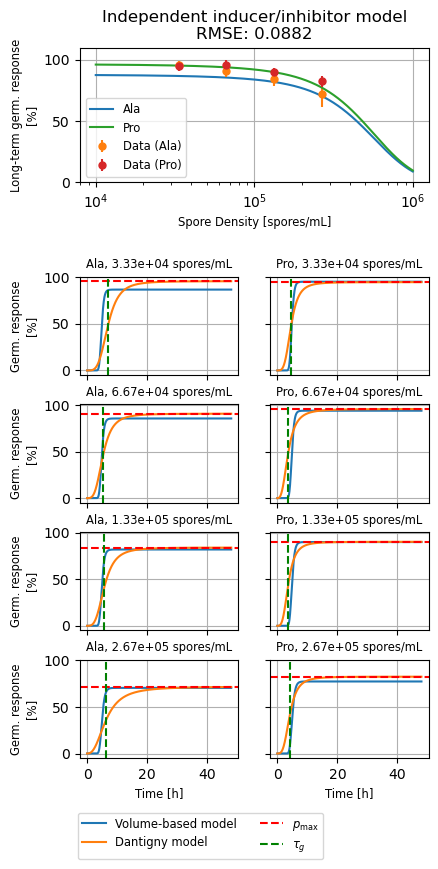

In [116]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_independent.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

plot_germination_data_fit_all("independent", false, params_test, times, sources, densities, p_maxs, taus, nus, errs)

The model does not appear to reproduce the expected time course of the Dantigny model or an accurate representation of the dataset.

### 3.2. Inducer-dependent inhibition

In the second group of models, the germination depends on the depletion of the inhibitor and the inducer affects either the rate of release (as represented by the permeability), the threshold for inhibition, or both. The germination probability is expressed as

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi, P_{\textrm{eff}})}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ \frac{1}{\sqrt{2\pi}\sigma_\xi}\exp{\left(-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}\right)}\ d{\xi}}.
\end{equation}
$$

#### 3.2.1. Inducer shifts inhibition threshold

In the first case, it is assumed that the permeability remains constant over all inducing media, but it is the inhibition threshold that changes. Therefore, the $\gamma$ parameter is split into three cases, corresponding to the three carbon sources.

In [6]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("inhibitor_thresh", def_params, dantigny_data, times, sources, densities, bounds_broad, p_maxs*0.01, max_steps=max_steps)

jldopen("Data/fit_inhibitor_thresh.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_broad
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Number of nodes: 216
Model: inducer-modulated inhibitor (threshold) with static inducer
Running first optimisation stage
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.75 secs, 6 evals, 3 steps, improv/step: 0.333 (last = 0.3333), fitness=806.735183145
1.34 secs, 18 evals, 9 steps, improv/step: 0.444 (last = 0.5000), fitness=713.448989308
1.94 secs, 29 evals, 15 steps, improv/step: 0.467 (last = 0.5000), fitness=512.316493714
2.45 secs, 40 evals, 21 steps, improv/step: 0.381 (last = 0.1667), fitness=512.316493714
3.03 secs, 52 evals, 27 steps, improv/step: 0.370 (last = 0.3333), fitness=512.316493714
3.56 secs, 63 evals, 33 steps, improv/step: 0.394 (last = 0.5000), fitness=512.316493714
4.08 secs, 73 evals, 38 steps, improv/step: 0.395 (last = 0.4000), fitness=512.316493714
4.61 secs, 84 evals, 45 steps, improv/step: 0.467 (last

Dict{Any, Any} with 3 entries:
  :σ_γ => [1.70538e-5, 3.49115e-5]
  :μ_γ => [2.81193e-5, 5.75594e-5]
  :Pₛ  => [0.000505099]

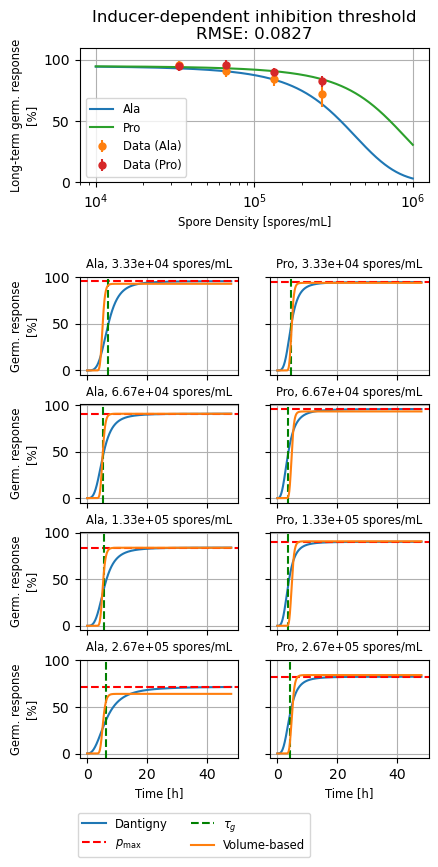

In [76]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_inhibitor_thresh.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

plot_germination_data_fit_all("inhibitor_thresh", false, params_test, times, sources, densities, p_maxs, taus, nus, errs)

#### 3.2.2. Inducer increases inhibitor permeation

In the second case, it is assumed that the inhibitor enhances the permeability of the inhibitor through the cell wall, accelerating its release. Hence, the threshold of inhibition remains the same, but $P_s$ varies across the carbon sources.

In [8]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("inhibitor_perm", def_params, dantigny_data, times, sources, densities, bounds_narrow, p_maxs*0.01, max_steps=max_steps)

jldopen("Data/fit_inhibitor_perm.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Number of nodes: 216
Model: inducer-modulated inhibitor (permeability) with static inducer
Running first optimisation stage
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.56 secs, 10 evals, 5 steps, improv/step: 0.600 (last = 0.6000), fitness=160.846271473
1.13 secs, 20 evals, 11 steps, improv/step: 0.545 (last = 0.5000), fitness=160.846271473
1.71 secs, 31 evals, 17 steps, improv/step: 0.529 (last = 0.5000), fitness=160.846271473
2.29 secs, 43 evals, 23 steps, improv/step: 0.565 (last = 0.6667), fitness=160.846271473
2.86 secs, 54 evals, 29 steps, improv/step: 0.483 (last = 0.1667), fitness=160.846271473
3.46 secs, 65 evals, 36 steps, improv/step: 0.472 (last = 0.4286), fitness=160.846271473
3.97 secs, 73 evals, 41 steps, improv/step: 0.488 (last = 0.6000), fitness=121.733570625
4.48 secs, 83 evals, 47 steps, improv/step: 0.468 

Dict{Any, Any} with 3 entries:
  :σ_γ => [2.19825e-5]
  :μ_γ => [3.6243e-5]
  :Pₛ  => [0.000406551, 0.000641149]

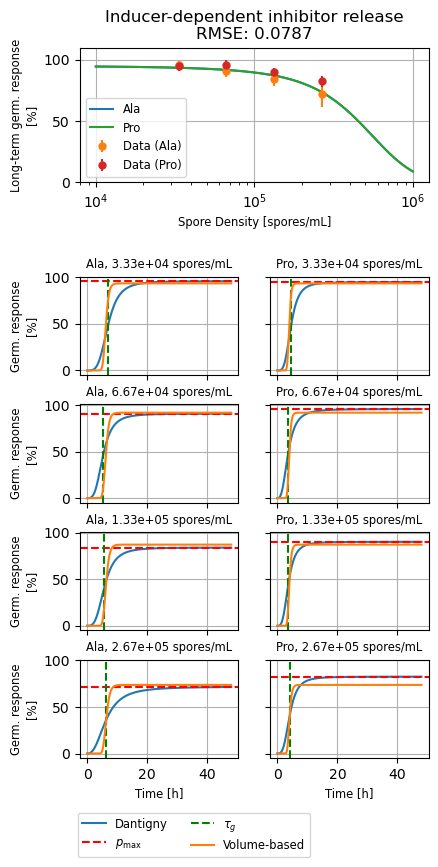

In [77]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_inhibitor_perm.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

plot_germination_data_fit_all("inhibitor_perm", false, params_test, times, sources, densities, p_maxs, taus, nus, errs)

#### 3.2.3. Inducer shifts inhibition threshold and increases inhibitor permeation

As a third option, the inducer is assumed to modulate both the inhibition threshold and the inhibitor permeation, making these parameters specific to each carbon source case.

In [10]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("inhibitor", def_params, dantigny_data, times, sources, densities, bounds_narrow, p_maxs*0.01, max_steps=max_steps)

jldopen("Data/fit_inhibitor.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Number of nodes: 216
Model: inducer-modulated inhibitor (combined) with static inducer
Running first optimisation stage
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.58 secs, 6 evals, 3 steps, improv/step: 0.333 (last = 0.3333), fitness=234.422951596
1.15 secs, 16 evals, 8 steps, improv/step: 0.250 (last = 0.2000), fitness=234.422951596
1.74 secs, 26 evals, 13 steps, improv/step: 0.308 (last = 0.4000), fitness=195.947651325
2.28 secs, 36 evals, 19 steps, improv/step: 0.316 (last = 0.3333), fitness=195.947651325
2.81 secs, 47 evals, 25 steps, improv/step: 0.320 (last = 0.3333), fitness=137.921979459
3.38 secs, 57 evals, 30 steps, improv/step: 0.367 (last = 0.6000), fitness=137.921979459
3.89 secs, 67 evals, 36 steps, improv/step: 0.417 (last = 0.6667), fitness=137.921979459
4.40 secs, 78 evals, 42 steps, improv/step: 0.429 (last 

Dict{Any, Any} with 3 entries:
  :σ_γ => [1.79874e-5, 2.84759e-5]
  :μ_γ => [2.96563e-5, 4.69488e-5]
  :Pₛ  => [0.000423774, 0.000612172]

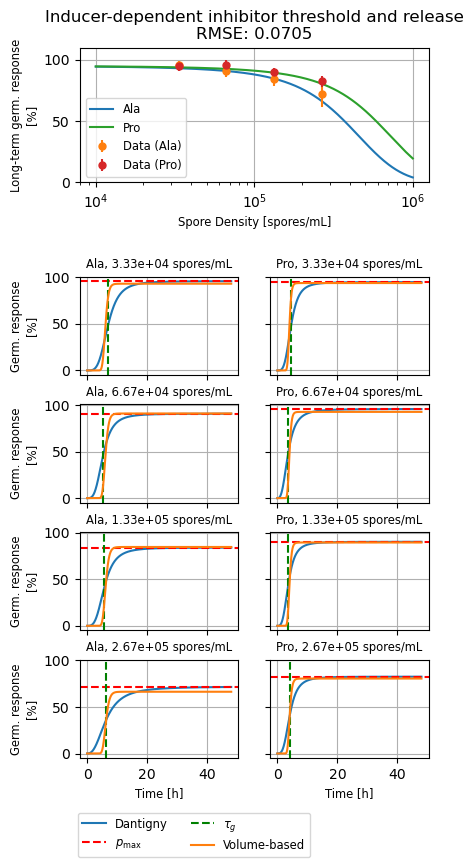

In [105]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_inhibitor.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

plot_germination_data_fit_all("inhibitor", false, params_test, times, sources, densities, p_maxs, taus, nus, errs)

### 3.3. Inhibitor-dependent carbon sensitivity

The third group of models examines the case in which the carbon source inducer triggers the germination programme, but its threshold or signalling strength are affected negatively by the presence of the inhibitor.

#### 3.3.1. Inhibitor shifts inducer threshold

In the first case, the residial concentration of inhibitor in the spore is assumed to shift the activation threshold for the carbon signalling. The germination probability is defined as follows:

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\Phi{\left(\frac{1-kc_{\textrm{in}}{(\xi, \psi)}-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ f_\xi{(\xi)}\ f_\psi{(\psi)}\ d{\xi}}\ d{\psi}},
\end{equation}
$$

with

$$
\begin{equation}
f_\psi{(\psi)} = \frac{1}{\sqrt{2\pi}\sigma_\psi}e^{-\frac{(\psi-\mu_\psi)^2}{2\sigma_\psi^2}},
\end{equation}
$$

$$
\begin{equation}
f_\xi{(\xi)} = \frac{1}{\sqrt{2\pi}\sigma_\xi}e^{-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}}.
\end{equation}
$$

The signal strength $s$ and the succeptibility toward inhibition $k$ are source-specific, while $\mu_{\omega_0}$ and $\sigma_{\omega_0}$ and the other free parameters remain constant over the medium compositions.

In [12]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("inducer_thresh", def_params, dantigny_data, times, sources, densities, bounds_broad, p_maxs*0.01, max_steps=max_steps)

jldopen("Data/fit_inducer_thresh.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_broad
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Number of nodes: 36
Model: inhibitor-modulated inducer (threshold) with static inducer
Running first optimisation stage
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.63 secs, 4 evals, 2 steps, improv/step: 1.000 (last = 1.0000), fitness=5263.345570643
1.37 secs, 8 evals, 4 steps, improv/step: 0.750 (last = 0.5000), fitness=2727.984930633
1.98 secs, 14 evals, 7 steps, improv/step: 0.714 (last = 0.6667), fitness=2699.815231359
2.55 secs, 18 evals, 9 steps, improv/step: 0.556 (last = 0.0000), fitness=2699.815231359
3.40 secs, 22 evals, 11 steps, improv/step: 0.636 (last = 1.0000), fitness=2699.815231359
3.95 secs, 27 evals, 14 steps, improv/step: 0.714 (last = 1.0000), fitness=2699.815231359
4.59 secs, 31 evals, 16 steps, improv/step: 0.688 (last = 0.5000), fitness=2699.815231359
5.27 secs, 35 evals, 18 steps, improv/step: 0.722 (l

Excessive output truncated after 524316 bytes.

Dict{Any, Any} with 6 entries:
  :σ_ψ => [0.052944]
  :k   => [2.12662, 1.27161]
  :μ_ω => [0.710958, 0.676735]
  :μ_ψ => [0.845491]
  :Pₛ  => [6.80917e-5]
  :σ_ω => [0.282433, 0.237605]

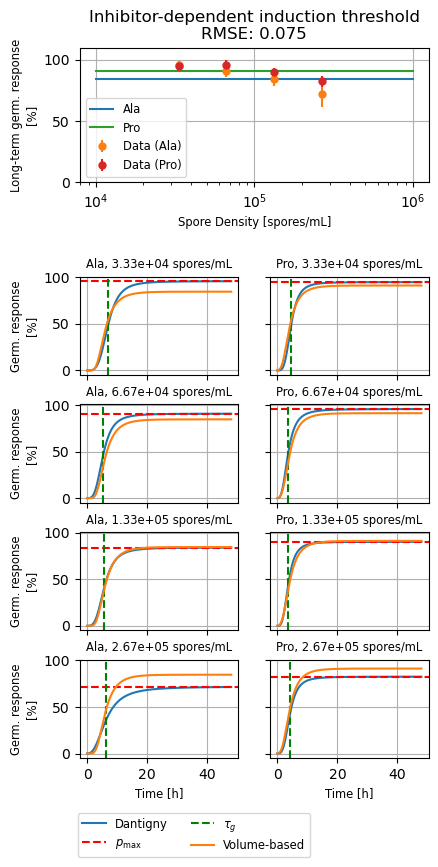

In [78]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_inducer_thresh.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

plot_germination_data_fit_all("inducer_thresh", false, params_test, times, sources, densities, p_maxs, taus, nus, errs, n_nodes=100)

#### 3.3.2. Inhibitor attenuates inducing signal

In the second scenario, the inhibitor is assumed to interfere with the signal strength by classic inhibitor kinetics. The probability for germination is

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\Phi{\left(\frac{\left[1+\left(\frac{c_{\textrm{in}}{(\xi, \psi)}}{K_I}\right)^n\right]^{-1}-\mu_\omega}{\sigma_\omega}\right)}\ f_\xi{(\xi)}\ f_\psi{(\psi)}\ d{\xi}}\ d{\psi}}.
\end{equation}
$$

Once again, $\mu_\omega$ and $\sigma_\omega$ are specific for the molecular species. As it is not known if the inhibitor interacts directly with the carbon molecules, with the receptor proteins or with elements further down the signalling pathway, it can be assumed that $K_I$ and $n$ also vary depending on the carbon source type. All other parameters reimain general to the system.

In [14]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("inducer_signal", def_params, dantigny_data, times, sources, densities, bounds_broad, p_maxs*0.01, max_steps=max_steps)

jldopen("Data/fit_inducer_signal.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_broad
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Dict{Any, Any} with 7 entries:
  :σ_ψ => [0.0172555]
  :K_I => [0.199171, 0.531634]
  :n   => [1.34506, 1.50876]
  :μ_ω => [0.728946, 0.820732]
  :μ_ψ => [0.628684]
  :Pₛ  => [6.68414e-5]
  :σ_ω => [0.263913, 0.136335]

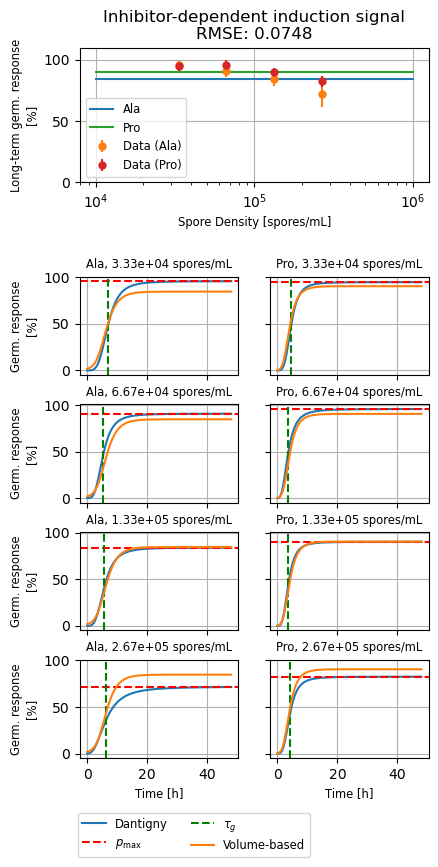

In [79]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_inducer_signal.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

plot_germination_data_fit_all("inducer_signal", false, params_test, times, sources, densities, p_maxs, taus, nus, errs)

#### 3.3.3. Inhibitor shifts inducer threshold and attenuates inducing signal

Finally, in the combined scenario, the probability becomes

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\Phi{\left(\frac{\left[1+\left(\frac{c_{\textrm{in}}{(\xi, \psi)}}{K_I}\right)^n\right]^{-1}-kc_{\textrm{in}}-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ f_\xi{(\xi)}\ f_\psi{(\psi)}\ d{\xi}}\ d{\psi}}.
\end{equation}
$$

This is the model with the most unknown parameters (13), with $s$, $k$, $K_I$ and $n$ varying per inducer and the rest remaining constant for each sub-dataset.

In [16]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("inducer", def_params, dantigny_data, times, sources, densities, bounds_broad, p_maxs*0.01, max_steps=max_steps)

jldopen("Data/fit_inducer.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_broad
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Dict{Any, Any} with 8 entries:
  :σ_ψ => [0.221485]
  :K_I => [0.984903, 0.440991]
  :k   => [3.27315, 1.74758]
  :n   => [2.48533, 2.63459]
  :μ_ω => [0.743559, 0.662131]
  :μ_ψ => [0.577215]
  :Pₛ  => [7.27254e-5]
  :σ_ω => [0.25029, 0.25292]

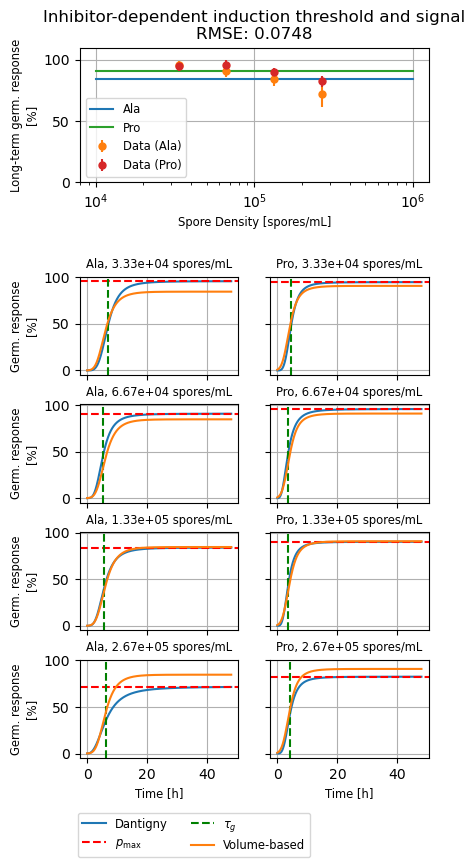

In [80]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_inducer.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

plot_germination_data_fit_all("inducer", false, params_test, times, sources, densities, p_maxs, taus, nus, errs, n_nodes=100)

## 4. Fitting procedures for a time-dependent inducer

Introducing a time-dependent increase of the inducer concentration by the formula

$$
\begin{equation}
c_{\textrm{cs}}{(t)}=c_{\textrm{cs}}^{\textrm{out}}(1-e^{-t/\tau_{\textrm{cs}}}),
\end{equation}
$$

in which the characteristic permeation time is defined as

$$
\begin{equation}
\tau_{\textrm{cs}}=\frac{V_{\textrm{cw}}}{P_s^{\textrm{cs}}A_s},\quad V_{\textrm{cw}}=0.24\,\frac{4}{3}\pi[(\xi-d_{\textrm{hp}})^3-(\xi-d_{\textrm{hp}}-\kappa)^3]
\end{equation}
$$

which increases the signalling strength via Michaelis-Menten kinetics:

$$
\begin{equation}
s{(c_{\textrm{cs}})}=\frac{c_{\textrm{cs}}}{K_{\textrm{cs}}+c_{\textrm{cs}}},
\end{equation}
$$

introduces two new unknown parameters: $P_s^{\textrm{cs}}$ and $K_{\textrm{cs}}$, and replaces the normalised parameter $s$ by a Michaelis-Menten function of the inducer saturation. All of these new parameters are medium-specific.

### 4.1. Independent induction/inhibition (time-dependent inducer)

As the signal is now dependent on the fluctuating spore radius and polysaccharide layer thickness, the germination probability changes to

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\Phi{\left(\frac{s{(\xi, \kappa, t)}-\mu_\omega}{\sigma_\omega}\right)}\left[1-\Phi{\left(\frac{\beta{(\xi, t)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ f_\kappa{(\kappa)}\ f_\xi{(\xi)}\ d{\kappa}}\ d{\xi}}.
\end{equation}
$$

While data is lacking on the conidial cell wall thickness, a reasonable guess yields an average of $200\ \textrm{nm}$ and a standard deviation of $50\ \textrm{nm}$.

In [18]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("independent", def_params, dantigny_data, times, sources, densities, bounds_narrow, p_maxs * 0.01, st=true, max_steps=max_steps)

jldopen("Data/fit_independent_st.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Dict{Any, Any} with 7 entries:
  :σ_γ   => [2.12033e-5]
  :K_cs  => [0.0035376, 0.00284264]
  :μ_ω   => [0.372849, 0.0848607]
  :μ_γ   => [3.75734e-5]
  :Pₛ    => [0.000634935]
  :σ_ω   => [0.142878, 0.00667108]
  :Pₛ_cs => [4.93752e-7, 0.000708513]

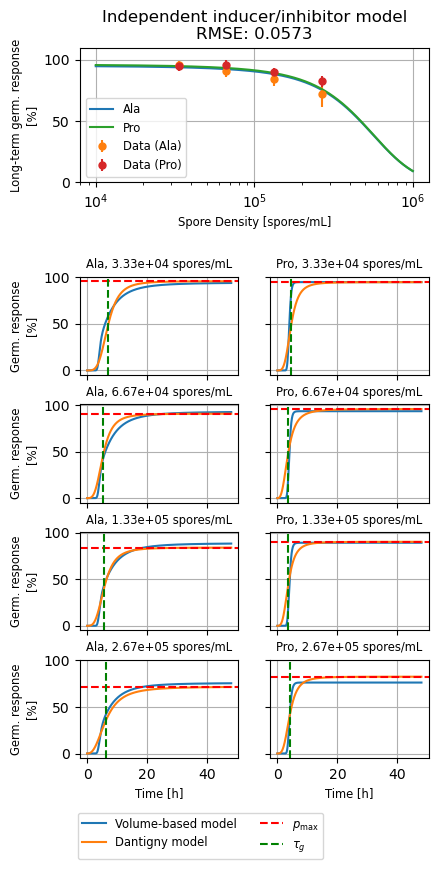

In [117]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_independent_st.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

plot_germination_data_fit_all("independent", true, params_test, times, sources, densities, p_maxs, taus, nus, errs)

### 4.2. Inducer-dependent inhibition (time-dependent inducer)

Under a time-dependent inducer signal, the three cases of inducer-dependent inhibition become as follows.

#### 4.2.1. Inducer shifts inhibition threshold

As the inducing signal now evolves over time, it cannot be absorbed into $\gamma$ and must therefore be explicitly included in the relationship $\gamma = \gamma_0 + ks$, where $k$ is a constant dictating the relative weight of the influence. There is still an inherent variation in $\gamma_0$, but it is shared among all carbon source cases, since $k$ captures the inducer-specificity. Therefore, the condition for germination becomes

$$
\begin{equation}
\beta < \gamma_0 + ks \quad \Longrightarrow \quad \beta - ks < \gamma_0
\end{equation}
$$

and the probability is

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi, P_{\textrm{eff}})}-ks{(\xi, \kappa, t)}-\mu_{\gamma_0}}{\sigma_{\gamma_0}}\right)}\right]\ f_\kappa{(\kappa)}\ f_\xi{(\xi)}\ d{\kappa}}\ d{\xi}}.
\end{equation}
$$

In [20]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("inhibitor_thresh", def_params, dantigny_data, times, sources, densities, bounds_broad, p_maxs * 0.01, st=true, max_steps=max_steps)

jldopen("Data/fit_inhibitor_thresh_st.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_broad
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Dict{Any, Any} with 6 entries:
  :σ_γ   => [0.0606531]
  :k     => [0.00247932, 0.00248574]
  :K_cs  => [9.9992, 9.99893]
  :μ_γ   => [0.1]
  :Pₛ    => [0.000103194]
  :Pₛ_cs => [1.45582e-7, 0.00139389]

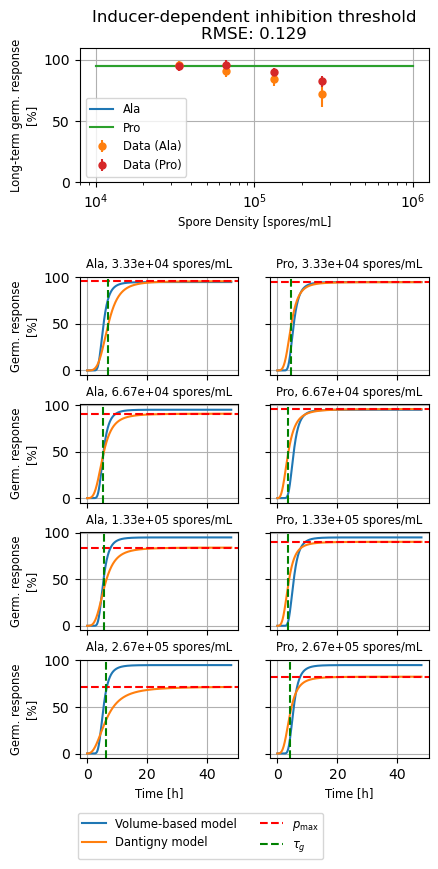

In [118]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_inhibitor_thresh_st.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

plot_germination_data_fit_all("inhibitor_thresh", true, params_test, times, sources, densities, p_maxs, taus, nus, errs, n_nodes=200)

#### 4.2.2. Inducer increases inhibitor permeation

There is insufficient data to define a plausible mechanism for the modulation of the inhibitor release by the inducing signal, so simple model can be adopted in which $P_{\textrm{eff}}=sP_{\textrm{eff}}^{\textrm{max}}$, i.e. the permeation constant is increased from zero to a maximum limit depending on the inducing signal. Since $s$ is a saturating quantity (due to its Michaelis-Menten kinetics), so would the modified permeability be. Hence, the probability becomes

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi, P_{\textrm{eff}}^{\textrm{max}}, s)}-\mu_{\gamma_0}}{\sigma_{\gamma_0}}\right)}\right]\ f_\kappa{(\kappa)}\ f_\xi{(\xi)}\ d{\kappa}}\ d{\xi}},
\end{equation}
$$

where

$$
\begin{equation}
\beta = \phi+(1-\phi)e^{-s{(\xi,\kappa,t)}P_{\textrm{eff}}^{\textrm{max}}\frac{A_s}{V_s(1-\phi)}t}.
\end{equation}
$$

In [22]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("inhibitor_perm", def_params, dantigny_data, times, sources, densities, bounds_narrow, p_maxs * 0.01, st=true, max_steps=max_steps)

jldopen("Data/fit_inhibitor_perm_st.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Dict{Any, Any} with 5 entries:
  :σ_γ   => [2.19824e-5]
  :K_cs  => [0.00956537, 0.00240618]
  :μ_γ   => [3.62428e-5]
  :Pₛ    => [0.000795428]
  :Pₛ_cs => [0.00491123, 0.00327707]

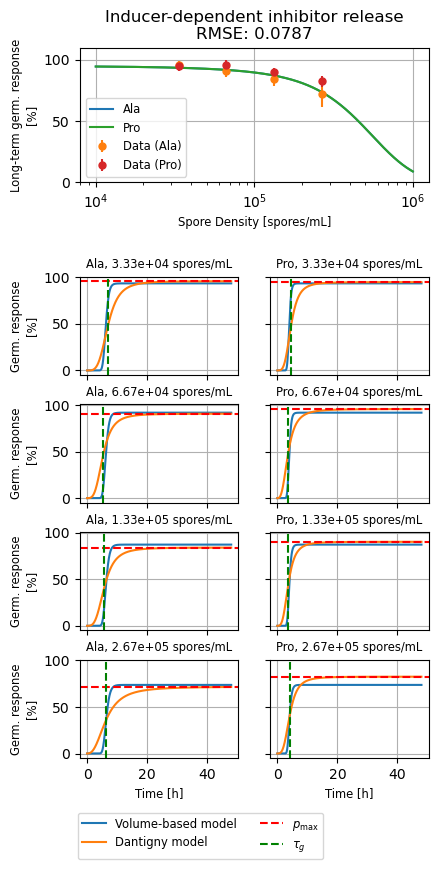

In [119]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_inhibitor_perm_st.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

plot_germination_data_fit_all("inhibitor_perm", true, params_test, times, sources, densities, p_maxs, taus, nus, errs)

#### 4.2.3. Inducer shifts inhibition and increases inhibitor permeation

When considering the combined effects of the inducer on the inhibitor, the probability becomes

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi, P_{\textrm{max}}, s)}-ks{(\xi, \kappa, t)}-\mu_{\gamma_0}}{\sigma_{\gamma_0}}\right)}\right]\ f_\kappa{(\kappa)}\ f_\xi{(\xi)}\ d{\kappa}}\ d{\xi}},
\end{equation}
$$

whereby one differentiates the effect on the threshold from the effect on the permeability by the proportionality constant $k$.

In [24]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("inhibitor", def_params, dantigny_data, times, sources, densities, bounds_broad, p_maxs * 0.01, st=true, max_steps=max_steps)

jldopen("Data/fit_inhibitor_st.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_broad
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Dict{Any, Any} with 6 entries:
  :σ_γ   => [0.0606527]
  :k     => [0.00253105, 0.00268694]
  :K_cs  => [1.21463, 0.751125]
  :μ_γ   => [0.0999994]
  :Pₛ    => [0.00999906]
  :Pₛ_cs => [0.00542056, 0.00980755]

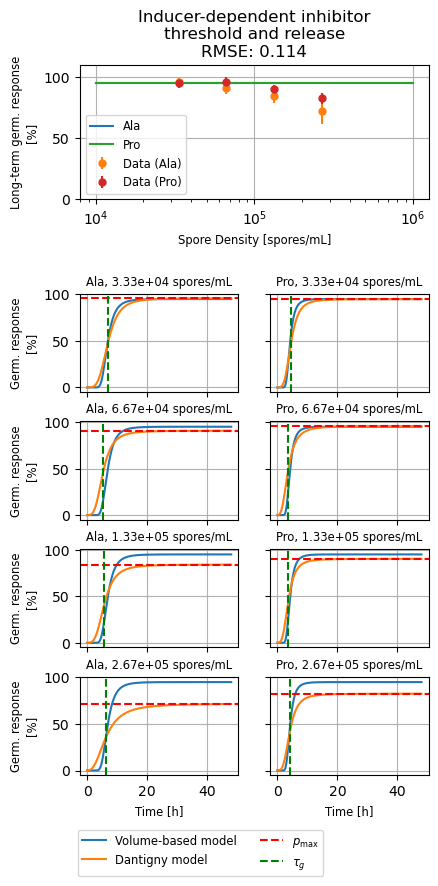

In [120]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_inhibitor_st.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

plot_germination_data_fit_all("inhibitor", true, params_test, times, sources, densities, p_maxs, taus, nus, errs, n_nodes=200)

### 4.3. Inhibitor-dependent carbon sensitivity (time-dependent inducer)

The time-dependence of the inducer permeation also bears consequences for the inhibitor-dependent carbon signalling, adding a second modification of the signalling pathway leading to germination.

#### 4.3.1. Inhibitor shifts inducer threshold

In the first scenario, the main change in the germination probability is the replacement of $s$ by its time-dependent counterpart and the integration over the inner cell wall thicknesses:

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\int_0^\infty{\Phi{\left(\frac{s{(\xi, \kappa, t)}-kc_{\textrm{in}}{(\xi, \psi)}-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ f_\kappa{(\kappa)}\ f_\xi{(\xi)}\ f_\psi{(\psi)}\ d{\kappa}}\ d{\xi}}\ d{\psi}}.
\end{equation}
$$

In [26]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("inducer_thresh", def_params, dantigny_data, times, sources, densities, bounds_narrow, p_maxs * 0.01, st=true, max_steps=max_steps)

jldopen("Data/fit_inducer_thresh_st.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Dict{Any, Any} with 8 entries:
  :σ_ψ   => [0.968016]
  :k     => [333.848, 86.7621]
  :K_cs  => [0.0543057, 0.0249319]
  :μ_ω   => [0.144775, 0.186214]
  :μ_ψ   => [0.999898]
  :Pₛ    => [0.000396856]
  :σ_ω   => [0.00721708, 0.0809543]
  :Pₛ_cs => [0.00508545, 0.00909459]

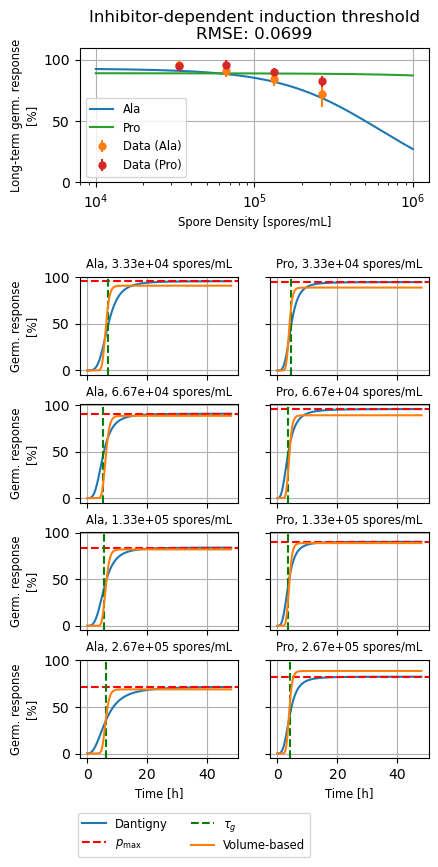

In [85]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_inducer_thresh_st.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

plot_germination_data_fit_all("inducer_thresh", true, params_test, times, sources, densities, p_maxs, taus, nus, errs, n_nodes=50)

#### 4.3.2. Inhibitor attentuates inducer signal

The same modification applies to the second scenario:

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\int_0^\infty{\Phi{\left(\frac{s{(\xi, \kappa, t)}\left[1+\left(\frac{c_{\textrm{in}}{(\xi, \psi)}}{K_I}\right)^n\right]^{-1}-\mu_\omega}{\sigma_\omega}\right)}\ f_\xi{(\kappa)}\ f_\xi{(\xi)}\ f_\psi{(\psi)}\ d{\kappa}}\ d{\xi}}\ d{\psi}}.
\end{equation}
$$

In [28]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("inducer_signal", def_params, dantigny_data, times, sources, densities, bounds_narrow, p_maxs * 0.01, st=true, max_steps=max_steps)

jldopen("Data/fit_inducer_signal_st.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Dict{Any, Any} with 9 entries:
  :σ_ψ   => [0.692563]
  :K_I   => [0.105811, 0.188457]
  :n     => [1.10956, 1.86537]
  :K_cs  => [0.0726483, 0.00196747]
  :μ_ω   => [0.0872774, 0.564246]
  :μ_ψ   => [0.983882]
  :Pₛ    => [0.000104466]
  :σ_ω   => [0.0332262, 0.209001]
  :Pₛ_cs => [0.00223877, 0.0004341]

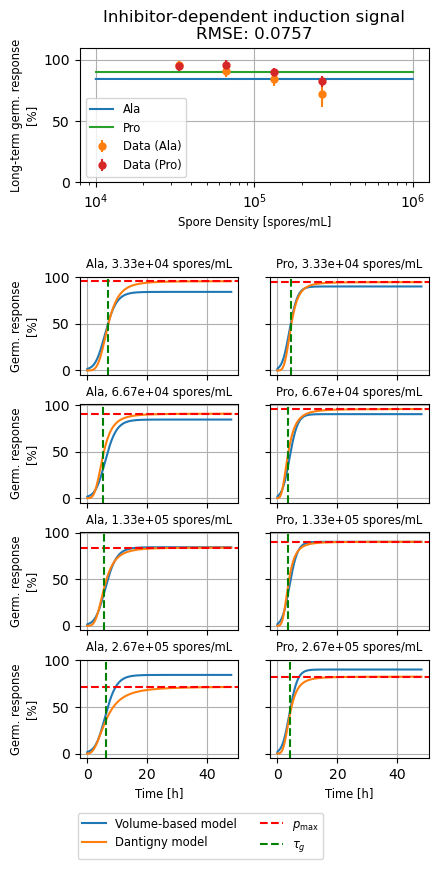

In [121]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_inducer_signal_st.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

plot_germination_data_fit_all("inducer_signal", true, params_test, times, sources, densities, p_maxs, taus, nus, errs)

#### 4.3.3. Inhibitor shifts inducer threshold and attenuates inducing signal

The combined case has the probability

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\int_0^\infty{\Phi{\left(\frac{s{(\xi, \kappa, t)}\left[1+\left(\frac{c_{\textrm{in}}{(\xi, \psi)}}{K_I}\right)^n\right]^{-1}-kc_{\textrm{in}}-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ f_\xi{(\kappa)}\ f_\xi{(\xi)}\ f_\psi{(\psi)}\ d{\kappa}}\ d{\xi}}\ d{\psi}}.
\end{equation}
$$

In [30]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("inducer", def_params, dantigny_data, times, sources, densities, bounds_narrow, p_maxs * 0.01, st=true, max_steps=max_steps)

jldopen("Data/fit_inducer_st.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Dict{Any, Any} with 10 entries:
  :σ_ψ   => [0.994085]
  :K_I   => [0.114424, 0.984328]
  :k     => [401.734, 27.1621]
  :K_cs  => [0.0639083, 0.0385334]
  :n     => [1.37581, 2.65127]
  :μ_ω   => [0.0932872, 0.139912]
  :μ_ψ   => [0.99647]
  :Pₛ    => [0.000345721]
  :σ_ω   => [0.0399202, 0.0533573]
  :Pₛ_cs => [0.00608614, 0.00427072]

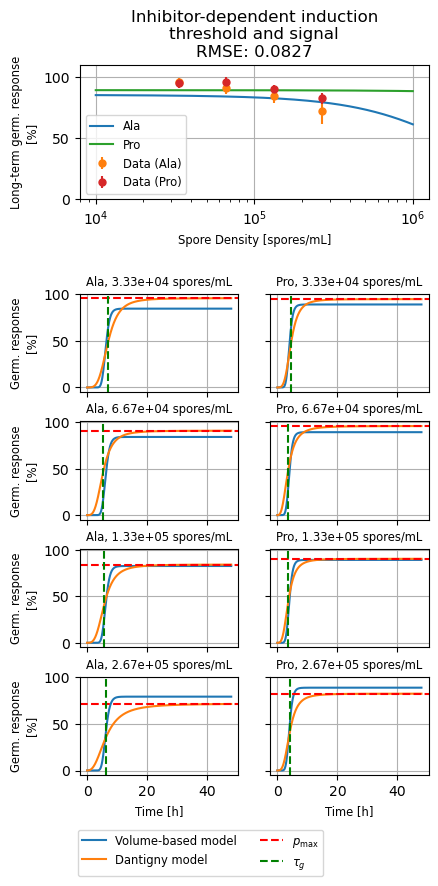

In [122]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_inducer_st.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

plot_germination_data_fit_all("inducer", true, params_test, times, sources, densities, p_maxs, taus, nus, errs, n_nodes=50)

## 5. Summary of results

The RMSE results from the fitting procedures on _A. niger_ data are summarized in the table below:

Interaction                              | Constant inducer | Slow-permeating inducer
-----------------------------------------|----------------|------------------------
Independent                              | 0.0882         | 0.0573
Inducer - inhibition threshold           | 0.0827         | 0.129
Inducer - inhibitor release              | 0.0787         | 0.0787
Inducer - inhibitor threshold + release  | 0.0705         | 0.114
Inhibitor - induction threshold          | 0.075          | 0.0699
Inhibitor - induction signal             | 0.0748         | 0.0757
Inhibitor - induction threshold + release| 0.0748         | 0.0827

<!-- The most successful fit is performed using the model with inhependent germination factors and a time-dependent induction. The second most successful fit is given by the model with inhibitor-dependent germination with inducer-dependent theshold and release. The flaw of these models is that its time evolution does not correctly capture the onset of germination as represented by the Dantigny model. A closer alignment in the onset curve is exhibited by the three induction-determined germination models with a time-dependent induction. Therefore, -->

An attempt can be made to combine some of these models in order to improve the current fitness.

## 6. Combined model

### 6.1. Two-factor germination under time-dependent inducer with an inducer-dependent inhibition threshold

Combining the model with an inducer-dependent inhibition threshold wtih an additional inducer-dependent germination criterion, one attains the formula

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\Phi\left(\frac{s{(\xi, \kappa, t)}-\mu_\omega}{\sigma_\omega}\right)\left[1-\Phi{\left(\frac{\beta{(\xi, P_{\textrm{eff}})}-ks{(\xi, \kappa, t)}-\mu_{\gamma_0}}{\sigma_{\gamma_0}}\right)}\right]\ f_\kappa{(\kappa)}\ f_\xi{(\xi)}\ d{\kappa}}\ d{\xi}}.
\end{equation}
$$

In [5]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("combined_inhibitor_thresh", def_params, dantigny_data, times, sources, densities, bounds_broad, p_maxs * 0.01, st=true, max_steps=max_steps)

jldopen("Data/fit_combined_inhibitor_thresh.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_broad
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Number of nodes: 36
Model: inducer-modulated inhibitor (combined) with time-dependent inducer
Running first optimisation stage
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
1.28 secs, 2 evals, 1 steps, improv/step: 1.000 (last = 1.0000), fitness=5296.501323631
2.22 secs, 4 evals, 2 steps, improv/step: 0.500 (last = 0.0000), fitness=5198.179029764
2.95 secs, 6 evals, 3 steps, improv/step: 0.667 (last = 1.0000), fitness=5198.179029764
3.83 secs, 8 evals, 4 steps, improv/step: 0.500 (last = 0.0000), fitness=5198.179029764
5.01 secs, 10 evals, 5 steps, improv/step: 0.600 (last = 1.0000), fitness=5198.179029764
6.11 secs, 13 evals, 7 steps, improv/step: 0.714 (last = 1.0000), fitness=5198.179029764
6.89 secs, 15 evals, 8 steps, improv/step: 0.750 (last = 1.0000), fitness=5198.179029764
7.69 secs, 17 evals, 9 steps, improv/step: 0.778 (

Dict{Any, Any} with 8 entries:
  :σ_γ   => [0.0536036]
  :k     => [0.0111257, 0.177666]
  :K_cs  => [1.89666, 0.00803969]
  :μ_ω   => [0.00356282, 0.316833]
  :μ_γ   => [0.0883846]
  :Pₛ    => [9.89337e-5]
  :σ_ω   => [0.00144162, 0.189693]
  :Pₛ_cs => [0.00209288, 0.00296213]

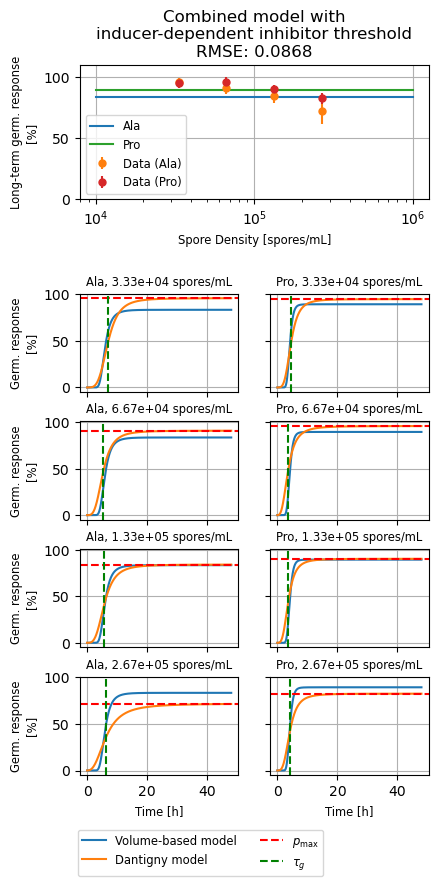

In [123]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_combined_inhibitor_thresh.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

plot_germination_data_fit_all("combined_inhibitor_thresh", true, params_test, times, sources, densities, p_maxs, taus, nus, errs, n_nodes=50)

### 6.2. Two-factor germination under time-dependent inducer with an inducer-dependent inhibitor release

Combining the model with an inducer-dependent inhibor release wtih an additional inducer-dependent germination criterion, one attains the formula

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\Phi\left(\frac{s{(\xi, \kappa, t)}-\mu_\omega}{\sigma_\omega}\right)\left[1-\Phi{\left(\frac{\beta{(\xi, P_{\textrm{eff}})}-ks{(\xi, \kappa, t)}-\mu_{\gamma_0}}{\sigma_{\gamma_0}}\right)}\right]\ f_\kappa{(\kappa)}\ f_\xi{(\xi)}\ d{\kappa}}\ d{\xi}}.
\end{equation}
$$

In [7]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("combined_inhibitor_perm", def_params, dantigny_data, times, sources, densities, bounds_broad, p_maxs * 0.01, st=true, max_steps=max_steps)

jldopen("Data/fit_combined_inhibitor_perm.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_broad
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Number of nodes: 36
Model: inducer-modulated inhibitor (release) with time-dependent inducer
Running first optimisation stage
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.94 secs, 2 evals, 1 steps, improv/step: 1.000 (last = 1.0000), fitness=5142.418101253
1.86 secs, 4 evals, 2 steps, improv/step: 1.000 (last = 1.0000), fitness=5142.418101253
3.16 secs, 7 evals, 4 steps, improv/step: 1.000 (last = 1.0000), fitness=5142.418101253
3.86 secs, 9 evals, 5 steps, improv/step: 1.000 (last = 1.0000), fitness=5142.418101253
4.66 secs, 11 evals, 6 steps, improv/step: 1.000 (last = 1.0000), fitness=5142.418101253
5.40 secs, 13 evals, 7 steps, improv/step: 1.000 (last = 1.0000), fitness=5142.418101253
6.35 secs, 15 evals, 8 steps, improv/step: 1.000 (last = 1.0000), fitness=5142.418101253
7.04 secs, 17 evals, 9 steps, improv/step: 1.000 (l

Dict{Any, Any} with 7 entries:
  :σ_γ   => [0.0604697]
  :K_cs  => [0.0103711, 0.00355051]
  :μ_ω   => [0.303315, 0.396562]
  :μ_γ   => [0.1]
  :Pₛ    => [0.000187631]
  :σ_ω   => [0.159297, 0.215163]
  :Pₛ_cs => [0.00692854, 0.00929393]

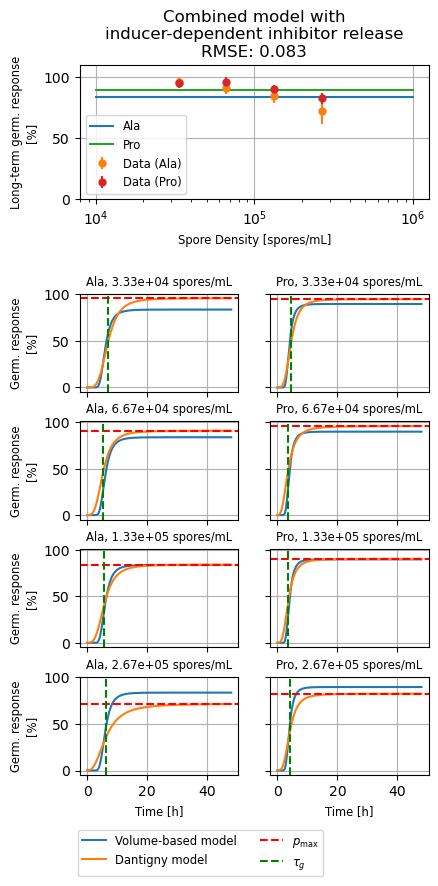

In [124]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_combined_inhibitor_perm.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

plot_germination_data_fit_all("combined_inhibitor_perm", true, params_test, times, sources, densities, p_maxs, taus, nus, errs, n_nodes=50)

### 6.3. Two-factor germination under time-dependent inducer with an inducer-dependent inhibitor threshold and release

Combining the model with an inducer-dependent inhibition threshold and release wtih an additional inducer-dependent germination criterion, one attains the formula

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\Phi\left(\frac{s{(\xi, \kappa, t)}-\mu_\omega}{\sigma_\omega}\right)\left[1-\Phi{\left(\frac{\beta{(\xi, P_{\textrm{max}}, s)}-ks{(\xi, \kappa, t)}-\mu_{\gamma_0}}{\sigma_{\gamma_0}}\right)}\right]\ f_\kappa{(\kappa)}\ f_\xi{(\xi)}\ d{\kappa}}\ d{\xi}}.
\end{equation}
$$

In [8]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("combined_inhibitor", def_params, dantigny_data, times, sources, densities, bounds_broad, p_maxs * 0.01, st=true, max_steps=max_steps)

jldopen("Data/fit_combined_inhibitor.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_broad
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Number of nodes: 36
Model: inducer-modulated inhibitor (combined) with time-dependent inducer
Running first optimisation stage
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
1.25 secs, 2 evals, 1 steps, improv/step: 1.000 (last = 1.0000), fitness=5296.501323631
1.99 secs, 4 evals, 2 steps, improv/step: 1.000 (last = 1.0000), fitness=5296.501323631
2.89 secs, 6 evals, 3 steps, improv/step: 1.000 (last = 1.0000), fitness=5296.501323631
3.66 secs, 8 evals, 4 steps, improv/step: 1.000 (last = 1.0000), fitness=5296.501323631
4.17 secs, 10 evals, 5 steps, improv/step: 1.000 (last = 1.0000), fitness=5296.501323631
4.72 secs, 12 evals, 6 steps, improv/step: 1.000 (last = 1.0000), fitness=5296.501323631
5.25 secs, 14 evals, 7 steps, improv/step: 1.000 (last = 1.0000), fitness=5296.501323631
5.91 secs, 16 evals, 8 steps, improv/step: 1.000 (

Dict{Any, Any} with 8 entries:
  :σ_γ   => [0.0248535]
  :k     => [0.00827678, 0.0339185]
  :K_cs  => [0.327552, 0.216683]
  :μ_ω   => [0.0190699, 0.0270846]
  :μ_γ   => [0.0448091]
  :Pₛ    => [0.00423056]
  :σ_ω   => [0.00973425, 0.0119917]
  :Pₛ_cs => [0.00100041, 0.00185189]

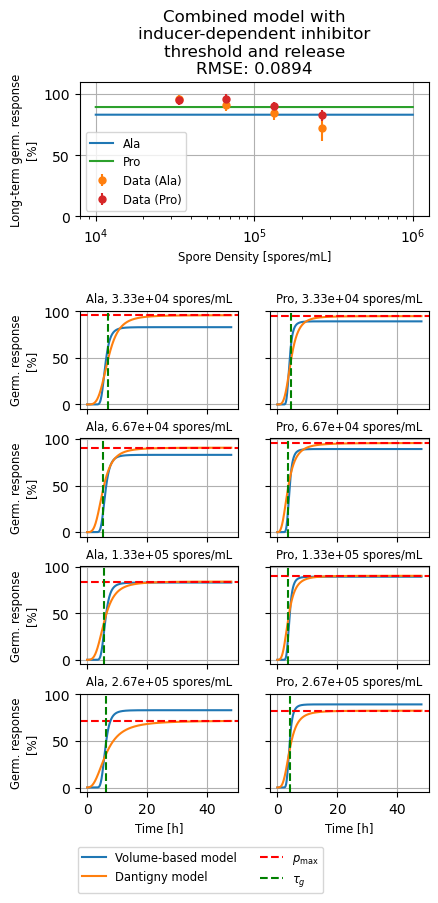

In [125]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_combined_inhibitor.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

plot_germination_data_fit_all("combined_inhibitor", true, params_test, times, sources, densities, p_maxs, taus, nus, errs, n_nodes=50)

### 6.4. Two-factor germination under time-dependent inducer with an inhibitor-dependent threshold

A combination is constructed using the simplest of the models with time and inhibitor-dependent induction, namely the inhibitor-modulated inducer threshold model, and the model with independent germination factors and a time-dependent induction. The germination probability for this combined model takes the form

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi, t)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\left[\int_0^\infty{\Phi{\left(\frac{s{(\xi, \kappa, t)}-kc_{\textrm{in}}{(\xi, \psi)}-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ f_\psi{(\psi)}\ d{\psi}}\right] f_\kappa{(\kappa)}\ f_\xi{(\xi)}\ d{\kappa}}\ d{\xi}}.
\end{equation}
$$

According to this model, both the depletion of the inhibitor and the saturation of the signal need to cross a threshold in order for germination to take place. The inhibition threshold $\gamma$ is independent from the carbon source, and so is the inhibitor permeability $P_{\textrm{eff}}$. What varies according to the type of inducer are the susceptibility of its threshold to inhibition, the half-saturation constant for the inhibitor modifying the signal strength, the inducing signal threshold and all inducer permeation parameters

In [ ]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("combined_inducer_thresh", def_params, dantigny_data, times, sources, densities, bounds_broad, p_maxs * 0.01, st=true, max_steps=max_steps)

jldopen("Data/fit_combined_inducer_thresh.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_broad
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Dict{Any, Any} with 10 entries:
  :σ_γ   => [4.30417e-6]
  :σ_ψ   => [0.00020058]
  :k     => [20.789, 0.546412]
  :K_cs  => [6.72466, 7.69244]
  :μ_ω   => [0.000830233, 0.000797752]
  :μ_γ   => [0.0782188]
  :μ_ψ   => [0.98732]
  :Pₛ    => [0.000423186]
  :σ_ω   => [0.000448784, 0.000406199]
  :Pₛ_cs => [0.00948545, 0.000963495]

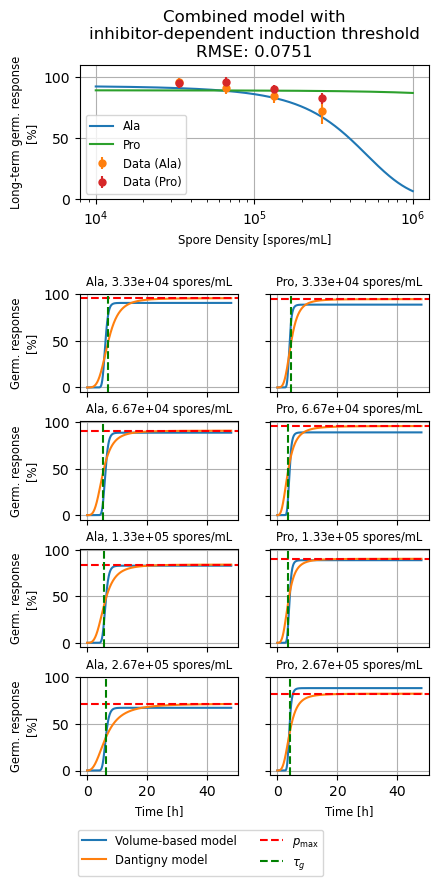

In [126]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_combined_inducer_thresh.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

plot_germination_data_fit_all("combined_inducer_thresh", true, params_test, times, sources, densities, p_maxs, taus, nus, errs, n_nodes=30)

The lack of improvement in the data-fit of the combined model is likely due a conflicting role of the inhibitor in triggering germination directly and shifting the induction threshold.

### 6.5. Two-factor germination under time-dependent inducer with an inhibitor-dependent signal

As a second attempt, a combined model incorporates inhibitor-dependent induction signal modulation in a two-factor germination probability:

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi, t)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\left[\int_0^\infty{\Phi{\left(\frac{s{(\xi, \kappa, t)}\left[1+\left(\frac{c_{\textrm{in}}{(\xi, \psi)}}{K_I}\right)^n\right]^{-1}-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ f_\psi{(\psi)}\ d{\psi}}\right] f_\kappa{(\kappa)}\ f_\xi{(\xi)}\ d{\kappa}}\ d{\xi}}.
\end{equation}
$$

In [ ]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("combined_inducer_signal", def_params, dantigny_data, times, sources, densities, bounds_narrow, p_maxs * 0.01, st=true, max_steps=max_steps)

jldopen("Data/fit_combined_inducer_signal.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Dict{Any, Any} with 11 entries:
  :σ_ψ   => [0.793989]
  :K_I   => [0.0193834, 0.605683]
  :n     => [1.29495, 2.6325]
  :K_cs  => [0.0147286, 0.032188]
  :μ_ψ   => [0.9846]
  :μ_ω   => [0.298377, 0.060636]
  :Pₛ    => [0.000639558]
  :σ_ω   => [0.0591104, 2.75915e-6]
  :σ_γ   => [2.07202e-5]
  :μ_γ   => [3.75636e-5]
  :Pₛ_cs => [1.95947e-6, 0.00568095]

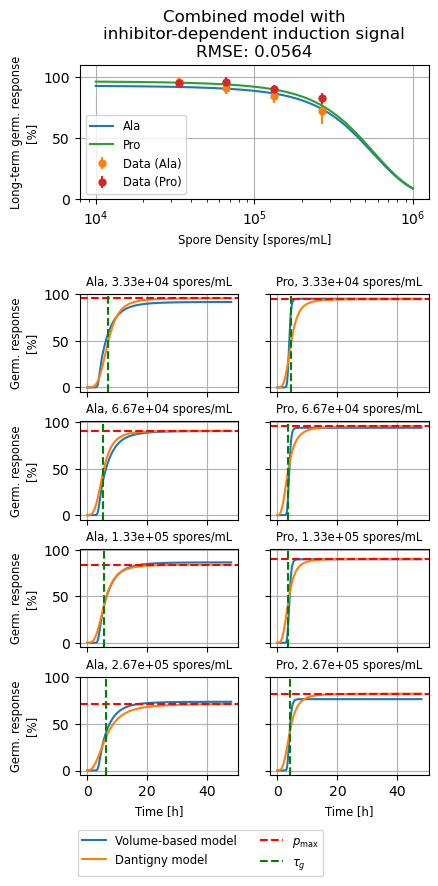

In [127]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_combined_inducer_signal.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

plot_germination_data_fit_all("combined_inducer_signal", true, params_test, times, sources, densities, p_maxs, taus, nus, errs, n_nodes=20)

### 6.6. Two-factor germination under time-dependent inducer with an inhibitor-dependent threshold and signal

Finally, the two-factor model can incorporate an inhibitor that determines both the time-dependent inducer signal and its threshold. The probability is formulated as follows:

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi, t)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\left[\int_0^\infty{\Phi{\left(\frac{s{(\xi, \kappa, t)}\left[1+\left(\frac{c_{\textrm{in}}{(\xi, \psi)}}{K_I}\right)^n\right]^{-1}-kc_{\textrm{in}}{(\xi, \psi)}-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ f_\psi{(\psi)}\ d{\psi}}\right] f_\kappa{(\kappa)}\ f_\xi{(\xi)}\ d{\kappa}}\ d{\xi}}.
\end{equation}
$$

In [ ]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("combined_inducer", def_params, dantigny_data, times, sources, densities, bounds_narrow, p_maxs * 0.01, st=true, max_steps=max_steps)

jldopen("Data/fit_combined_inducer.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Dict{Any, Any} with 12 entries:
  :σ_ψ   => [0.0145326]
  :K_I   => [0.00233632, 0.662103]
  :n     => [2.75745, 1.00689]
  :K_cs  => [0.0823055, 0.041054]
  :μ_ψ   => [0.854175]
  :μ_ω   => [0.0960888, 0.0380915]
  :Pₛ    => [0.00051449]
  :σ_ω   => [0.00697607, 0.00163448]
  :k     => [346.877, 198.285]
  :σ_γ   => [2.9083e-5]
  :μ_γ   => [4.93689e-5]
  :Pₛ_cs => [0.00899185, 0.00468161]

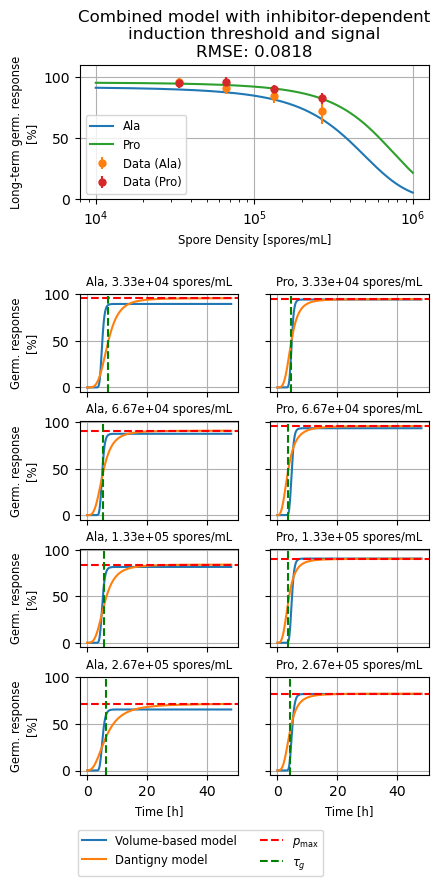

In [128]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_combined_inducer.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

plot_germination_data_fit_all("combined_inducer", true, params_test, times, sources, densities, p_maxs, taus, nus, errs, n_nodes=20)

## 7. Variable permeability

As an additional study, the assumption of a singular permeation constant can be discarded, incorporating a potential variation in e.g. the density of the cell wall. Thus, $P_{\textrm{eff}}$ is replaced by a random variable $\pi_{\textrm{eff}}$, with a mean $\mu_\pi$ and a standard deviation $\sigma_\pi$.

This model extension is applied to the two more successful yet relatively simple models from the first batch - the combined inducer effect on inhibition with a constant inducer and the independent germination factors with a time-dependent inducer.

### 7.1. Inducer-dependent inhibitor threshold and release (constant inducer and varying permeability)

The germination probability in the first case can be formulated as follows:

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi, \pi_{\textrm{eff}})}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ f_\pi{(\pi_{\textrm{eff}})}\ f_\xi{(\xi)}\ d{\pi_{\textrm{eff}}}}\ d{\xi}}.
\end{equation}
$$

In [38]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("special_inhibitor", def_params, dantigny_data, times, sources, densities, bounds_broad, p_maxs * 0.01, st=true, max_steps=max_steps)

jldopen("Data/fit_special_inhibitor.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_broad
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Dict{Any, Any} with 4 entries:
  :σ_γ => [1.83898e-5, 4.29456e-5]
  :μ_π => [0.000588147]
  :μ_γ => [3.03197e-5, 7.08958e-5]
  :σ_π => [0.000334124]

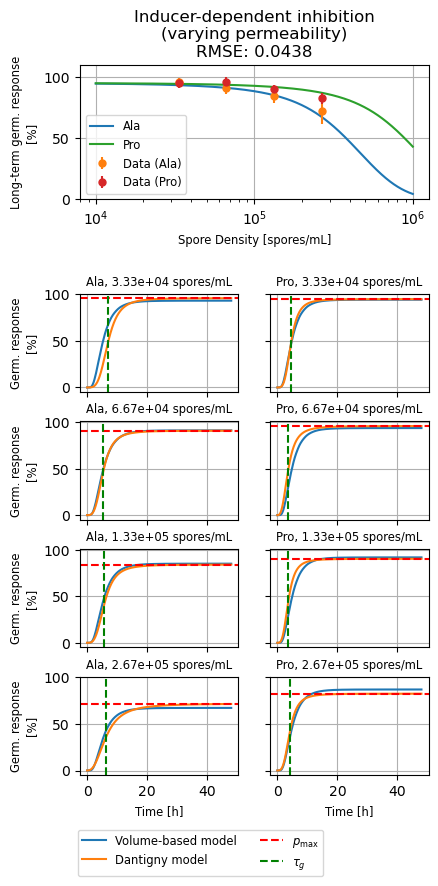

In [129]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_special_inhibitor.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

plot_germination_data_fit_all("special_inhibitor", true, params_test, times, sources, densities, p_maxs, taus, nus, errs)

### 7.2. Inhibitor-dependent induction threshold and signal (time-dependent inducer and varying permeability)

In the second case, the variation of the cell wall consistency can influence both the permeation constant of the inhibitor, $P_{\textrm{eff}}^{\textrm{inh}}$, and the permeation constant of the carbon signal, $P_{\textrm{eff}}^{\textrm{cs}}$. The variation is expected to be correlated in both cases, e.g. as a factor $\alpha$ determining the fraction of the cell wall covered by pores. Thus, the two permeation constants would be inherently derived from their diffusion coefficients as

$$
\begin{equation}
P_{\textrm{eff}}=\frac{\alpha D}{d}=\alpha P_{\textrm{base}}.
\end{equation}
$$

Therefore, the newly introduced random variable in this case, perturbing the permeabilities from their baseline values, is $\alpha$, with a mean $\mu_\alpha$ and a standard deviation $\sigma_\alpha$. With this, the germination probability becomes

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\int_0^\infty{\int_0^\infty{\Phi{\left(\frac{s{(\xi, \kappa, t)}\left[1+\left(\frac{c_{\textrm{in}}{(\xi, \psi)}}{K_I}\right)^n\right]^{-1}-kc_{\textrm{in}}{(\xi, \psi, \alpha)}-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ f_\alpha{(\alpha)}\ f_\kappa{(\kappa)}\ f_\xi{(\xi)}\ f_\psi{(\psi)}\ d{\alpha}}\ d{\kappa}}\ d{\xi}}\ d{\psi}}.
\end{equation}
$$

In [8]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("special_inducer", def_params, dantigny_data, times, sources, densities, bounds_broad, p_maxs * 0.01, st=true, max_steps=max_steps)

jldopen("Data/fit_special_inducer.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_broad
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Number of nodes: 6
Model: inhibitor-modulated inducer (combined) with time-dependent inducer and varying permeability
Running first optimisation stage
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
1.07 secs, 2 evals, 1 steps, improv/step: 1.000 (last = 1.0000), fitness=5296.501323631
2.22 secs, 4 evals, 2 steps, improv/step: 1.000 (last = 1.0000), fitness=5296.501323631
3.41 secs, 6 evals, 3 steps, improv/step: 1.000 (last = 1.0000), fitness=5270.621353113
4.27 secs, 8 evals, 4 steps, improv/step: 1.000 (last = 1.0000), fitness=5270.621353113
4.79 secs, 9 evals, 5 steps, improv/step: 1.000 (last = 1.0000), fitness=5018.983197463
5.80 secs, 11 evals, 6 steps, improv/step: 1.000 (last = 1.0000), fitness=5018.983197463
6.62 secs, 13 evals, 7 steps, improv/step: 1.000 (last = 1.0000), fitness=5018.983197463
7.72 secs, 15 evals, 8 step

Dict{Any, Any} with 12 entries:
  :σ_α   => [0.475206]
  :σ_ψ   => [0.209743]
  :K_I   => [0.919829, 0.763168]
  :n     => [1.92256, 2.21928]
  :K_cs  => [0.655051, 0.0446419]
  :μ_ψ   => [0.64779]
  :μ_α   => [0.949087]
  :μ_ω   => [0.00799686, 0.102626]
  :Pₛ    => [0.00051247]
  :σ_ω   => [0.00429015, 0.0601171]
  :k     => [338.461, 169.906]
  :Pₛ_cs => [0.0086655, 0.00320413]

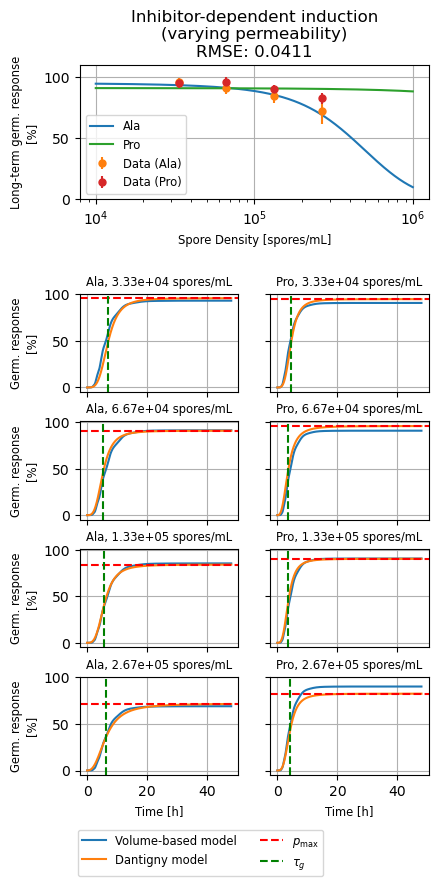

In [130]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_special_inducer.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

plot_germination_data_fit_all("special_inducer", true, params_test, times, sources, densities, p_maxs, taus, nus, errs, n_nodes=12)

### 7.3. Independent germination factors (time-dependent inducer and varying permeability)

Similarly, the germination probability in the third case becomes

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\int_0^\infty{\Phi{\left(\frac{s{(\xi, \kappa, t)}-\mu_\omega}{\sigma_\omega}\right)}\left[1-\Phi{\left(\frac{\beta{(\xi, \alpha, t)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ f_\alpha{(\alpha)}\ f_\kappa{(\kappa)}\ f_\xi{(\xi)\ d{\alpha}}}\ d{\kappa}}\ d{\xi}}.
\end{equation}
$$


In [40]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("special_independent", def_params, dantigny_data, times, sources, densities, bounds_narrow, p_maxs * 0.01, st=true, max_steps=max_steps)

jldopen("Data/fit_special_independent.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Dict{Any, Any} with 9 entries:
  :σ_γ   => [1.74451e-5]
  :σ_α   => [0.54609]
  :K_cs  => [0.0891373, 0.0002453]
  :μ_ω   => [0.0641591, 0.0685792]
  :μ_γ   => [3.7113e-5]
  :Pₛ    => [0.000637132]
  :σ_ω   => [0.027081, 1.0373e-5]
  :Pₛ_cs => [0.00222335, 0.00880448]
  :μ_α   => [0.962902]

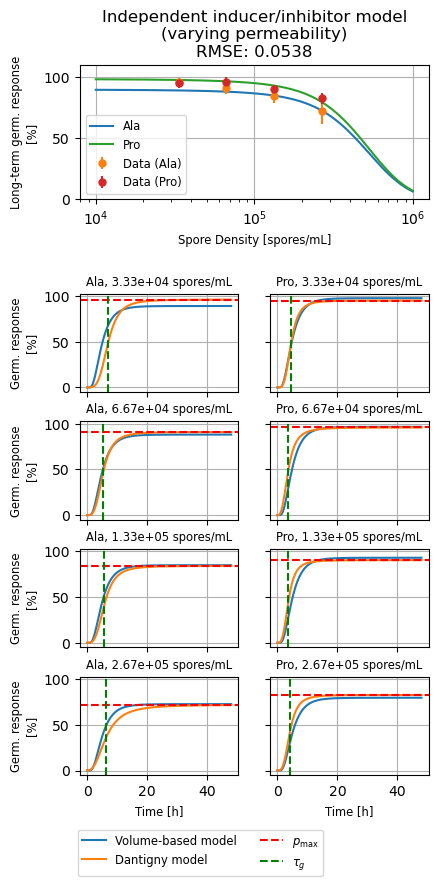

In [131]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_special_independent.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

plot_germination_data_fit_all("special_independent", true, params_test, times, sources, densities, p_maxs, taus, nus, errs, n_nodes=50)

### 7.4. Two-factor germination with inhibitor-dependent induction threshold (time-dependent inducer and varying permeability)

The probability for this is

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi, \alpha)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\int_0^\infty{\int_0^\infty{\Phi{\left(\frac{s{(\xi, \kappa)}-kc_{\textrm{in}}{(\xi, \psi, \alpha)}-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ f_\psi{(\psi)}\ f_\kappa{(\kappa)}\ f_\alpha{(\alpha)}\ f_\xi{(\xi)}\ d{\psi}}\ d{\kappa}}\ d{\alpha}}\ d{\xi}}.
\end{equation}
$$

In [6]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("special_combined_thresh", def_params, dantigny_data, times, sources, densities, bounds_narrow, p_maxs * 0.01, st=true, max_steps=max_steps)

jldopen("Data/fit_special_combined_thresh.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Number of nodes: 6
Model: 2-factor germination with inhibitor-modulated inducer (combined), time-dependent inducer and varying permeability
Running first optimisation stage
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
1.08 secs, 2 evals, 1 steps, improv/step: 1.000 (last = 1.0000), fitness=5278.179543059
2.62 secs, 4 evals, 2 steps, improv/step: 1.000 (last = 1.0000), fitness=5200.930427085
3.74 secs, 6 evals, 3 steps, improv/step: 1.000 (last = 1.0000), fitness=5200.930427085
4.91 secs, 8 evals, 4 steps, improv/step: 1.000 (last = 1.0000), fitness=5200.930427085
5.74 secs, 10 evals, 5 steps, improv/step: 0.800 (last = 0.0000), fitness=5197.365920826
6.71 secs, 12 evals, 6 steps, improv/step: 0.667 (last = 0.0000), fitness=4022.378416901
7.89 secs, 14 evals, 7 steps, improv/step: 0.571 (last = 0.0000), fitness=4022.378416901
8.89

Excessive output truncated after 524297 bytes.

Dict{Any, Any} with 14 entries:
  :σ_α   => [0.351331]
  :σ_ψ   => [0.799964]
  :K_I   => [0.943051, 0.693364]
  :n     => [1.14758, 1.33585]
  :K_cs  => [0.079408, 0.0130993]
  :μ_ψ   => [0.992267]
  :μ_α   => [0.662351]
  :μ_ω   => [0.0928344, 0.0910182]
  :Pₛ    => [0.00089396]
  :σ_ω   => [0.010798, 0.000544996]
  :k     => [403.409, 23.1694]
  :σ_γ   => [2.45577e-5]
  :μ_γ   => [4.69308e-5]
  :Pₛ_cs => [0.00699694, 0.00874135]

In [5]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_special_combined_thresh.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(params_opt)

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

# plot_germination_data_fit_all("special_combined_thresh", true, params_test, times, sources, densities, p_maxs, taus, nus, errs, n_nodes=20)

Dict{Any, Any}(:σ_α => [0.3513313343178929], :σ_ψ => [0.7999642947663571], :K_I => [0.9430514784284965, 0.6933638655827085], :n => [1.147577673771479, 1.3358457591787778], :K_cs => [0.07940799247012321, 0.01309925659947419], :k => [403.40935274926983, 23.169446048601404], :μ_ψ => [0.9922674217192949], :μ_α => [0.6623510096221129], :σ_γ => [2.4557748823120765e-5], :μ_ω => [0.09283442099143283, 0.09101819619438566], :μ_γ => [4.6930838023040345e-5], :Pₛ => [0.000893959550507763], :σ_ω => [0.010797980115941476, 0.0005449961534223716], :Pₛ_cs => [0.006996936292741403, 0.00874135419388315])
0.04771368141465255


Dict{Any, Any} with 20 entries:
  :Pₛ_cs => [0.00699694, 0.00874135]
  :σ_α   => [0.351331]
  :σ_ψ   => [0.799964]
  :c₀_cs => 0.01
  :d_hp  => 0.01
  :σ_κ   => 0.05
  :K_I   => [0.943051, 0.693364]
  :n     => [1.14758, 1.33585]
  :K_cs  => [0.079408, 0.0130993]
  :k     => [403.409, 23.1694]
  :μ_κ   => 0.2
  :μ_ψ   => [0.992267]
  :μ_α   => [0.662351]
  :σ_γ   => [2.45577e-5]
  :μ_ω   => [0.0928344, 0.0910182]
  :μ_γ   => [4.69308e-5]
  :Pₛ    => [0.00089396]
  :σ_ξ   => 0.3
  :σ_ω   => [0.010798, 0.000544996]
  :μ_ξ   => 2.65

### 7.5. Two-factor germination with inhibitor-dependent induction signal (time-dependent inducer and varying permeability)

The probability for this is

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi, \alpha)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\int_0^\infty{\int_0^\infty{\Phi{\left(\frac{s{(\xi, \kappa)}\left[1+\left(\frac{c_{\textrm{in}}{(\xi, \psi)}}{K_I}\right)^n\right]^{-1}-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ f_\psi{(\psi)}\ f_\kappa{(\kappa)}\ f_\alpha{(\alpha)}\ f_\xi{(\xi)}\ d{\psi}}\ d{\kappa}}\ d{\alpha}}\ d{\xi}}.
\end{equation}
$$

In [8]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("special_combined_signal", def_params, dantigny_data, times, sources, densities, bounds_narrow, p_maxs * 0.01, st=true, max_steps=max_steps)

jldopen("Data/fit_special_combined_signal.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Dict{Any, Any} with 14 entries:
  :σ_α   => [0.436007]
  :σ_ψ   => [0.298689]
  :K_I   => [0.347839, 0.6826]
  :n     => [2.47535, 2.65875]
  :K_cs  => [0.0404928, 0.0558907]
  :μ_ψ   => [0.948406]
  :μ_α   => [0.774708]
  :μ_ω   => [0.178049, 0.0535778]
  :Pₛ    => [0.000789133]
  :σ_ω   => [0.0124634, 0.000204042]
  :k     => [403.411, 254.449]
  :σ_γ   => [1.97225e-5]
  :μ_γ   => [4.15671e-5]
  :Pₛ_cs => [0.00177173, 0.00675126]

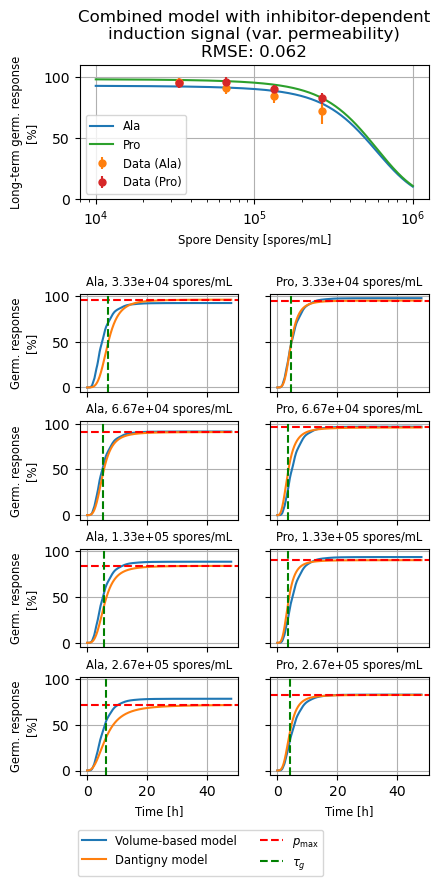

In [133]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_special_combined_signal.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

plot_germination_data_fit_all("special_combined_signal", true, params_test, times, sources, densities, p_maxs, taus, nus, errs, n_nodes=20)


### 7.6. Two-factor germination with inhibitor-dependent induction threshold and signal (time-dependent inducer and varying permeability)

Augmenting a combination of the last two models with a variable permeation yields the following germination probability:

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi, \alpha)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\int_0^\infty{\int_0^\infty{\Phi{\left(\frac{s{(\xi, \kappa)}\left[1+\left(\frac{c_{\textrm{in}}{(\xi, \psi)}}{K_I}\right)^n\right]^{-1}-kc_{\textrm{in}}{(\xi, \psi, \alpha)}-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ f_\psi{(\psi)}\ f_\kappa{(\kappa)}\ f_\alpha{(\alpha)}\ f_\xi{(\xi)}\ d{\psi}}\ d{\kappa}}\ d{\alpha}}\ d{\xi}}.
\end{equation}
$$

In [5]:
max_steps = 10000
params_opt, rmse = fit_model_to_data("special_combined", def_params, dantigny_data, times, sources, densities, bounds_narrow, p_maxs * 0.01, st=true, max_steps=max_steps)

jldopen("Data/fit_special_combined.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds_narrow
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Number of nodes: 6
Model: 2-factor germination with inhibitor-modulated inducer (combined), time-dependent inducer and varying permeability
Running first optimisation stage
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
1.39 secs, 2 evals, 1 steps, improv/step: 1.000 (last = 1.0000), fitness=5296.501323631
2.47 secs, 4 evals, 2 steps, improv/step: 1.000 (last = 1.0000), fitness=5296.501323631
3.45 secs, 6 evals, 3 steps, improv/step: 1.000 (last = 1.0000), fitness=5296.501323631
4.67 secs, 8 evals, 4 steps, improv/step: 1.000 (last = 1.0000), fitness=5296.501323631
5.76 secs, 10 evals, 5 steps, improv/step: 0.800 (last = 0.0000), fitness=5152.701868014
6.99 secs, 12 evals, 6 steps, improv/step: 0.833 (last = 1.0000), fitness=5152.701868014
8.19 secs, 14 evals, 7 steps, improv/step: 0.857 (last = 1.0000), fitness=5152.701868014
9.44

Excessive output truncated after 524310 bytes.

25.543429378
4360.83 secs, 9787 evals, 9710 steps

Dict{Any, Any} with 14 entries:
  :σ_α   => [0.381926]
  :σ_ψ   => [0.809859]
  :K_I   => [0.572961, 0.302369]
  :n     => [2.77864, 2.10211]
  :K_cs  => [0.0129572, 0.0270372]
  :μ_ψ   => [0.992624]
  :μ_α   => [0.75311]
  :μ_ω   => [0.420224, 0.0734144]
  :Pₛ    => [0.000813705]
  :σ_ω   => [0.00734031, 3.62947e-6]
  :k     => [400.271, 117.248]
  :σ_γ   => [2.4422e-5]
  :μ_γ   => [4.49937e-5]
  :Pₛ_cs => [0.00543185, 0.000635234]

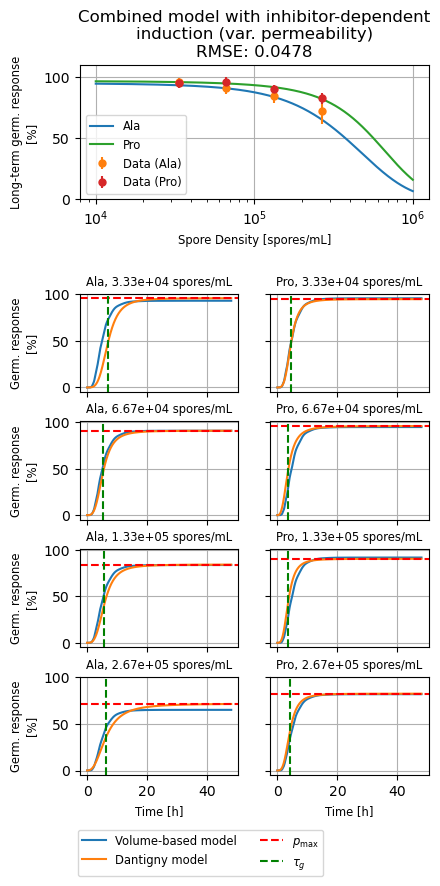

In [134]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params_opt, bounds_opt, params_opt, max_steps_opt, rmse = jldopen("Data/fit_special_combined.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

println(rmse)

# Load default and fitted parameters
params_test = merge(def_params, params_opt)

plot_germination_data_fit_all("special_combined", true, params_test, times, sources, densities, p_maxs, taus, nus, errs, n_nodes=16)

## 8. Final compilation of the results

The fitted parameters and RMSE values from all experiments presented so far are compiled in a $\LaTeX$ table.

In [5]:
println(summarise_fitted_parameters("A_niger_fitting", model_types=["special_independent", "special_combined_thresh"]))

Processing file: fit_combined_inducer
combined_inducer not in label_keys_sort, skipping...
Processing file: fit_combined_inducer_signal
combined_inducer_signal not in label_keys_sort, skipping...
Processing file: fit_combined_inducer_thresh
combined_inducer_thresh not in label_keys_sort, skipping...
Processing file: fit_combined_inhibitor
combined_inhibitor not in label_keys_sort, skipping...
Processing file: fit_combined_inhibitor_perm
combined_inhibitor_perm not in label_keys_sort, skipping...
Processing file: fit_combined_inhibitor_thresh
combined_inhibitor_thresh not in label_keys_sort, skipping...
Processing file: fit_independent
Processing file: fit_independent_st
independent not in label_keys_sort, skipping...
Processing file: fit_inducer
Processing file: fit_inducer_signal
Processing file: fit_inducer_signal_st
inducer_signal not in label_keys_sort, skipping...
Processing file: fit_inducer_st
inducer not in label_keys_sort, skipping...
Processing file: fit_inducer_thresh
Proces

## References

- [1] Ijadpanahsaravi, Maryam, L. Basten Snoek, Wieke R. Teertstra and Han A. B. Wösten. “The impact of inter- and intra-species spore density on germination of the food spoilage fungus Aspergillus niger.” _International journal of food microbiology_ 410 (2023): 110495 .
- [2] Ijadpanahsaravi, M., Teertstra, W.R., & Wösten, H.A. (2022). Inter- and intra-species heterogeneity in germination of Aspergillus conidia. Antonie Van Leeuwenhoek, 115, 1151 - 1164.